<a href="https://colab.research.google.com/github/MonthitaAre/first-year-project/blob/main/punishment_severity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 2.3 MB/s eta 0:00:00


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Mean Squared Error: 40.83799442560114
R-squared: -0.14556746976408697
Mean Absolute Error: 5.111158175166055


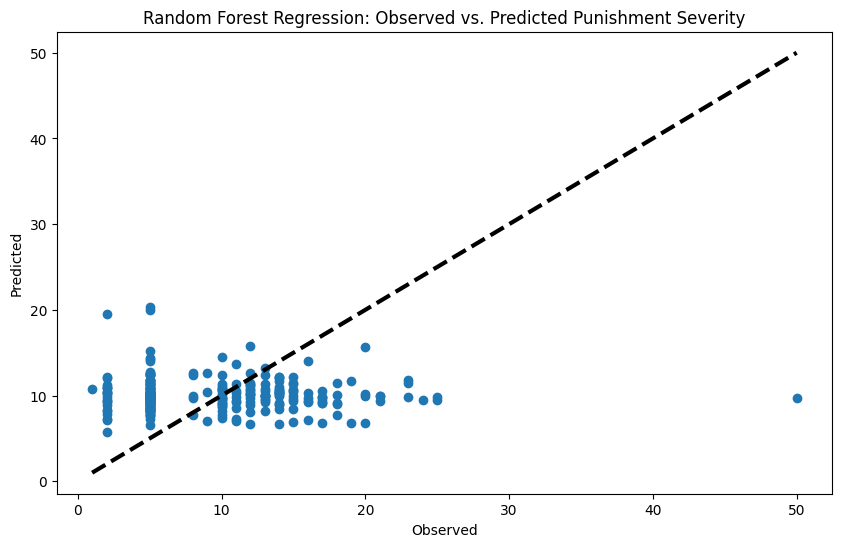

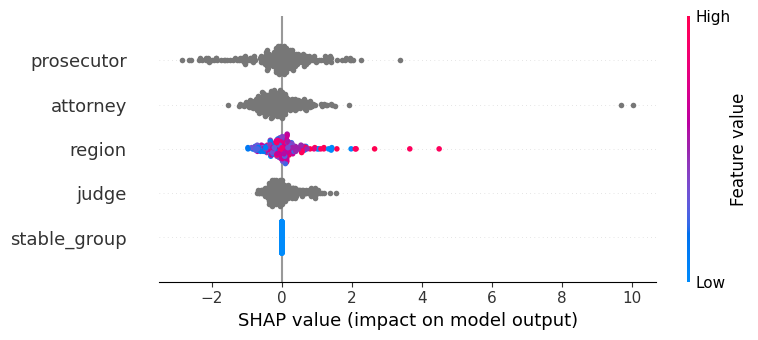

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for classifier: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Precision: 0.9919678714859438
Recall: 0.9427480916030534
F1-Score: 0.9667318982387475
ROC-AUC: 0.4713740458015267
Total number of court cases: 1316
Number of cases with stable working groups: 1316
A stable working group refers to a combination of judge, prosecutor, and defense attorney who work together on multiple cases, suggesting a consistent working relationship.


In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import shap

# Load the dataset
file_path = '/content/test_termpaper.xlsx'  # Adjust the path accordingly
data = pd.read_excel(file_path)

# Ensure all entries in 'text' column are string
data['text'] = data['text'].astype(str)

# Function to extract judge, prosecutor, and attorney names from the court decision text
def extract_names(text):
    # Define patterns with variations for Russian grammar (cases)
    judge_patterns = [
        re.compile(r'судья\s+([\w\s]+(?:в|а|е|ой|ью)?)', re.IGNORECASE),
        re.compile(r'председательствующий\s+([\w\s]+(?:в|а|е|ой|ью)?)', re.IGNORECASE),
        re.compile(r'председатель\s+([\w\s]+(?:в|а|е|ой|ью)?)', re.IGNORECASE)
    ]
    prosecutor_patterns = [
        re.compile(r'прокурор\s+([\w\s]+(?:а|у|ом|е)?)', re.IGNORECASE),
        re.compile(r'государственный\s+обвинитель\s+([\w\s]+(?:а|у|ом|е)?)', re.IGNORECASE),
        re.compile(r'обвинитель\s+([\w\s]+(?:а|у|ом|е)?)', re.IGNORECASE)
    ]
    attorney_patterns = [
        re.compile(r'адвокат\s+([\w\s]+(?:а|у|ом|е)?)', re.IGNORECASE),
        re.compile(r'защитник\s+([\w\s]+(?:а|у|ом|е)?)', re.IGNORECASE),
        re.compile(r'представитель\s+([\w\s]+(?:а|у|ом|е)?)', re.IGNORECASE)
    ]

    def search_patterns(patterns, text):
        for pattern in patterns:
            match = pattern.search(text)
            if match:
                return match.group(1).strip()
        return None

    judge_name = search_patterns(judge_patterns, text)
    prosecutor_name = search_patterns(prosecutor_patterns, text)
    attorney_name = search_patterns(attorney_patterns, text)

    return {
        'judge': judge_name,
        'prosecutor': prosecutor_name,
        'attorney': attorney_name
    }

# Function to extract case outcome and punishment details from the court decision text
def extract_case_details(text):
    outcome_pattern = re.compile(r'(виновен|невиновен|оправдан|осужден|приговорил)', re.IGNORECASE)
    punishment_pattern_years = re.compile(r'(\d+)\s*лет', re.IGNORECASE)
    punishment_pattern_months = re.compile(r'(\д+)\с*месяцев', re.IGNORECASE)
    colony_pattern = re.compile(r'(общего режима|строгого режима|особого режима)', re.IGNORECASE)
    fine_pattern = re.compile(r'штраф\s*в\s*размере\s*(\д+)', re.IGNORECASE)
    additional_restrictions_pattern = re.compile(r'(запрет|ограничение\s*на\s*\w+)', re.IGNORECASE)
    probation_pattern = re.compile(r'условно\s*на\s*(\д+)\с*лет', re.IGNORECASE)
    pre_trial_detention_pattern = re.compile(r'временное\s*содержание\s*под\s*стражей\s*(\д+)\с*дней', re.IGNORECASE)

    outcome_match = outcome_pattern.search(text)
    punishment_years_match = punishment_pattern_years.search(text)
    punishment_months_match = punishment_pattern_months.search(text)
    colony_match = colony_pattern.search(text)
    fine_match = fine_pattern.search(text)
    additional_restrictions_match = additional_restrictions_pattern.search(text)
    probation_match = probation_pattern.search(text)
    pre_trial_detention_match = pre_trial_detention_pattern.search(text)

    # Initialize punishment severity to 0
    punishment_severity = 0

    # Add years and months to punishment severity
    if punishment_years_match:
        punishment_severity += int(punishment_years_match.group(1))
    if punishment_months_match:
        punishment_severity += int(punishment_months_match.group(1)) / 12

    # Add fine to punishment severity (normalized to years)
    if fine_match:
        punishment_severity += int(fine_match.group(1)) / 10000  # Example normalization factor

    # Add penal colony type to punishment severity
    if colony_match:
        if 'общего режима' in colony_match.group(1).lower():
            punishment_severity += 2  # Reflecting general regime conditions
        elif 'строгого режима' in colony_match.group(1).lower():
            punishment_severity += 5  # Reflecting stricter conditions
        elif 'особого режима' in colony_match.group(1).lower():
            punishment_severity += 10  # Reflecting the harshest conditions

    # Subtract years for probation
    if probation_match:
        punishment_severity -= int(probation_match.group(1))

    # Add pre-trial detention to punishment severity (converted to years)
    if pre_trial_detention_match:
        punishment_severity += int(pre_trial_detention_match.group(1)) / 365

    # Add additional restrictions to punishment severity
    if additional_restrictions_match:
        punishment_severity += 1  # Arbitrary value for additional restrictions

    return {
        'outcome': outcome_match.group(1).lower() if outcome_match else None,
        'punishment_severity': punishment_severity if punishment_severity > 0 else None
    }

# Extract names and case details from each row in the dataset
data['names_extracted'] = data['text'].apply(extract_names)
data['case_details'] = data['text'].apply(extract_case_details)

# Create separate columns for judge, prosecutor, attorney, outcome, and punishment_severity
data['judge'] = data['names_extracted'].apply(lambda x: x['judge'])
data['prosecutor'] = data['names_extracted'].apply(lambda x: x['prosecutor'])
data['attorney'] = data['names_extracted'].apply(lambda x: x['attorney'])
data['outcome'] = data['case_details'].apply(lambda x: x['outcome'])
data['punishment_severity'] = data['case_details'].apply(lambda x: x['punishment_severity'])

# Drop rows with missing values in the new columns
data = data.dropna(subset=['judge', 'prosecutor', 'attorney', 'outcome', 'punishment_severity'])

# Ensure that the relevant columns are numeric
data.loc[:, 'punishment_severity'] = pd.to_numeric(data['punishment_severity'], errors='coerce')
data.loc[:, 'region'] = pd.to_numeric(data['region'], errors='coerce')

# Convert categorical features to numeric codes
data.loc[:, 'region'] = data['region'].astype('category').cat.codes
data.loc[:, 'judge'] = data['judge'].astype('category').cat.codes
data.loc[:, 'prosecutor'] = data['prosecutor'].astype('category').cat.codes
data.loc[:, 'attorney'] = data['attorney'].astype('category').cat.codes

# Identify stable working groups (combination of judge, prosecutor, and attorney appearing at least once)
group_counts = data.groupby(['judge', 'prosecutor', 'attorney']).size().reset_index(name='counts')
stable_groups = group_counts[group_counts['counts'] >= 1]

# Merge back to the main dataset to mark stable working groups
data = data.merge(stable_groups, on=['judge', 'prosecutor', 'attorney'], how='left', indicator='stable_group')
data['stable_group'] = data['stable_group'] == 'both'

# Convert stable_group to integer for analysis
data['stable_group'] = data['stable_group'].astype(int)

# Ensure no NaN values remain in critical columns
data = data.dropna(subset=['punishment_severity', 'region', 'stable_group'])

# Regression analysis for punishment severity (Random Forest)
X_reg = data[['region', 'stable_group', 'judge', 'prosecutor', 'attorney']]
y_reg = data['punishment_severity']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Hyperparameter tuning for Random Forest Regressor
param_grid_reg = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_reg = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid_reg, cv=5, n_jobs=-1, verbose=2)
grid_search_reg.fit(X_train_reg, y_train_reg)
best_params_reg = grid_search_reg.best_params_
print(f'Best parameters: {best_params_reg}')

rf_regressor = RandomForestRegressor(**best_params_reg, random_state=42)
rf_regressor.fit(X_train_reg, y_train_reg)

y_pred_reg = rf_regressor.predict(X_test_reg)
mse_reg = mean_squared_error(y_test_reg, y_pred_reg)
r2_reg = r2_score(y_test_reg, y_pred_reg)
mae_reg = mean_absolute_error(y_test_reg, y_pred_reg)
print(f'Mean Squared Error: {mse_reg}')
print(f'R-squared: {r2_reg}')
print(f'Mean Absolute Error: {mae_reg}')

# Ensure the output directory exists
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

# Save the model evaluation results
with open(f'{output_dir}/results.txt', 'w') as f:
    f.write(f'Mean Squared Error: {mse_reg}\n')
    f.write(f'R-squared: {r2_reg}\n')
    f.write(f'Mean Absolute Error: {mae_reg}\n')

# Plot the regression results
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg)
plt.plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], 'k--', lw=3)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Random Forest Regression: Observed vs. Predicted Punishment Severity')
plt.savefig(f'{output_dir}/punishment_severity_rf_plot.png')
plt.show()

# Feature importance analysis using SHAP
explainer = shap.TreeExplainer(rf_regressor)
shap_values = explainer.shap_values(X_test_reg)
shap.summary_plot(shap_values, X_test_reg)

# Classification Analysis with SMOTE
data['outcome_binary'] = data['outcome'].apply(lambda x: 1 if x in ['виновен', 'осужден', 'приговорил'] else 0)
X_classification = data[['region', 'stable_group', 'judge', 'prosecutor', 'attorney']]
y_classification = data['outcome_binary']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_clf_smote, y_train_clf_smote = smote.fit_resample(X_train_clf, y_train_clf)

# Hyperparameter tuning for Random Forest Classifier
param_grid_clf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_clf, cv=5, n_jobs=-1, verbose=2)
grid_search_clf.fit(X_train_clf_smote, y_train_clf_smote)
best_params_clf = grid_search_clf.best_params_
print(f'Best parameters for classifier: {best_params_clf}')

rf_classifier = RandomForestClassifier(**best_params_clf, random_state=42)
rf_classifier.fit(X_train_clf_smote, y_train_clf_smote)

y_pred_clf = rf_classifier.predict(X_test_clf)
precision = precision_score(y_test_clf, y_pred_clf)
recall = recall_score(y_test_clf, y_pred_clf)
f1 = f1_score(y_test_clf, y_pred_clf)
roc_auc = roc_auc_score(y_test_clf, y_pred_clf)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

# Print the number of court cases and stable working groups
total_cases = len(data)
stable_group_cases = data['stable_group'].sum()

print(f"Total number of court cases: {total_cases}")
print(f"Number of cases with stable working groups: {stable_group_cases}")

print("A stable working group refers to a combination of judge, prosecutor, and defense attorney who work together on multiple cases, suggesting a consistent working relationship.")
